<a href="https://colab.research.google.com/github/amr-elbana/EcoSortAI-Classifier/blob/main/notebooks/Augmented_waste_efficientnetB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB2

In [ ]:
# Define paths and constants
data_dir = "/content/drive/MyDrive/DL_Project/RealWaste-augmented-final"
val_dir = "/content/drive/MyDrive/DL_Project/RealWaste-val"
test_dir = "/content/drive/MyDrive/DL_Project/RealWaste-test"
batch_size = 32
target_size = (224, 224)
epochs = 100

In [ ]:
# import os
# from PIL import Image
# import numpy as np
# from imgaug import augmenters as iaa
# import math

# # Define the paths
# dataset_path = "/content/drive/MyDrive/DL_Project/RealWaste"  # Augmented dataset path
# augmented_path = "/content/drive/MyDrive/DL_Project/RealWaste-augmented-final"  # Output path for augmented dataset

# # Augmentation pipeline
# augmenter = iaa.Sequential([
#     iaa.Fliplr(0.5),  # Horizontal flip
#     iaa.Flipud(0.5),  # Vertical flip
#     iaa.Affine(rotate=(-20, 20)),  # Random rotation
#     iaa.Multiply((0.8, 1.2)),  # Brightness adjustment
#     iaa.GaussianBlur(sigma=(0, 1.0))  # Apply Gaussian blur
# ])

# # Ensure the output folders exist
# for class_name in os.listdir(dataset_path):
#     os.makedirs(os.path.join(augmented_path, class_name), exist_ok=True)

# # Function to augment images
# def augment_images(class_path, output_path, target_count):
#     images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
#     existing_count = len(images)
#     augment_needed = target_count - existing_count

#     if augment_needed <= 0:
#         # Copy existing images to the augmented folder
#         for img_path in images:
#             img_name = os.path.basename(img_path)
#             output_img_path = os.path.join(output_path, img_name)
#             if not os.path.exists(output_img_path):
#                 Image.open(img_path).save(output_img_path)
#         return

#     images = [Image.open(img_path) for img_path in images]
#     images_np = [np.array(img) for img in images]

#     for i in range(augment_needed):
#         img_np = augmenter.augment_image(images_np[i % existing_count])  # Augment image
#         augmented_img = Image.fromarray(img_np)
#         augmented_img.save(os.path.join(output_path, f"aug_{i+1}.jpg"))

# # Get the maximum number of images in any class
# max_images = max(len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in os.listdir(dataset_path))

# # Calculate target count per class (5x the maximum count)
# target_count = max_images * 5

# # Augment each class to the target count
# for class_name in os.listdir(dataset_path):
#     class_path = os.path.join(dataset_path, class_name)
#     output_class_path = os.path.join(augmented_path, class_name)
#     augment_images(class_path, output_class_path, target_count)


In [ ]:
# Create an ImageDataGenerator with EfficientNetB2 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNetB2-specific preprocessing
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to EfficientNetB2 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Create an ImageDataGenerator with VGG16 preprocessing and data augmentation
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16-specific preprocessing
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,      # Resize images to VGG16 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)


# ... (rest of the code remains the same)

# Check the number of samples in each generator
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 16749 images belonging to 2 classes.
Found 761 images belonging to 2 classes.
Training samples: 16749
Validation samples: 761
Training batches per epoch: 524
Validation batches per epoch: 24


In [ ]:
# Create an ImageDataGenerator for EfficientNetB2 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # EfficientNetB2-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # efficientnetB2 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 950 images belonging to 2 classes.
Test samples: 950
Test batches: 30


In [ ]:
import os
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
def create_model():
    # Load EfficientNetB2 model with pretrained weights, excluding the top (fully connected) layers
    efficientnet_base = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of EfficientNetB2 to retain the pre-trained weights
    efficientnet_base.trainable = False
    # Build the model
    model = Sequential([
        efficientnet_base,  # Add the entire base model
        GlobalAveragePooling2D(),  # Use global pooling instead of Flatten, This is more efficient and typically used for pre-trained convolutional models.
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # For binary classification
    ])

    # Compile the model
    optimizer = SGD(learning_rate=0.0001, momentum=0.9)  # Lower learning rate
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

# Define the model
model = create_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 7, 7, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         360,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,195,322 (31.26 MB)

 Trainable params: 426,753 (1.63 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model # Import load_model

# Define callbacks
model = load_model("/content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Waste_Augmented_EfficientNetB2_35-0.93.keras")

checkpoint_path = "/content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Waste_Augmented_EfficientNetB2_{epoch:02d}-{val_accuracy:0.2f}.keras"

# ModelCheckpoint: Save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Save the best model based on validation accuracy
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',         # Focus on reducing overfitting
    patience=5,                # Allow enough time for gradual improvements
    restore_best_weights=True,  # Load the best weights after stopping
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Adjust learning rate if validation loss doesn't improve
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=2,          # Wait 5 epochs before reducing
    min_lr=1e-6,         # Set a minimum learning rate
    verbose=1
)
# Train the model
History = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[checkpoint, early_stopping_monitor, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9117 - loss: 0.8736
Epoch 1: val_accuracy improved from -inf to 0.92641, saving model to /content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Waste_Augmented_EfficientNetB2_01-0.93.keras
524/524 ━━━━━━━━━━━━━━━━━━━━ 3682s 7s/step - accuracy: 0.9117 - loss: 0.8736 - val_accuracy: 0.9264 - val_loss: 0.8396 - learning_rate: 1.0000e-04
Epoch 2/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9131 - loss: 0.8658
Epoch 2: val_accuracy improved from 0.92641 to 0.92904, saving model to /content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Waste_Augmented_EfficientNetB2_02-0.93.keras
524/524 ━━━━━━━━━━━━━━━━━━━━ 125s 210ms/step - accuracy: 0.9131 - loss: 0.8658 - val_accuracy: 0.9290 - val_loss: 0.8328 - learning_rate: 1.0000e-04
Epoch 3/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9180 - loss: 0.8528
Epoch 3: val_accuracy improved from 0.92904 to 0.93167, saving model to /content/drive/MyDrive/DL_Proje

TypeError: cannot pickle 'module' object

In [ ]:
model.save('/content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Augmented_EfficientNetB2_best_model.keras')


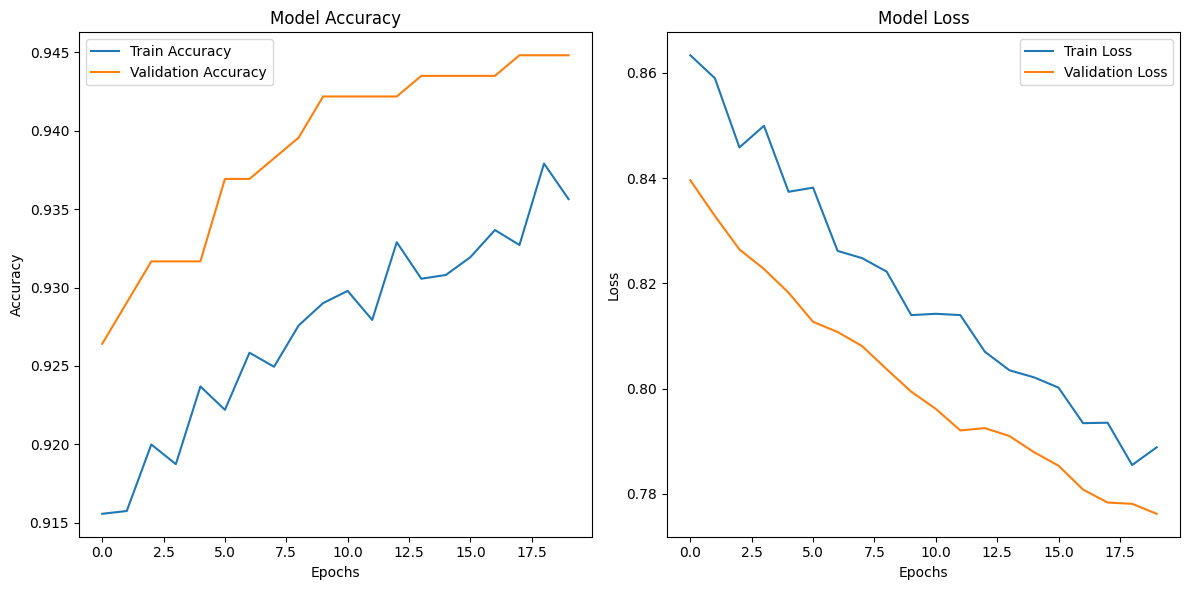

In [ ]:
import matplotlib.pyplot as plt

# Extract the training history
history = History.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
final_train_acc = History.history['accuracy'][-1]
final_val_acc = History.history['val_accuracy'][-1]
final_train_loss = History.history['loss'][-1]
final_val_loss = History.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9356
Final Validation Accuracy: 0.9448
Final Training Loss: 0.7889
Final Validation Loss: 0.7762


In [ ]:
if 'lr' in History.history:
    plt.plot(History.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

In [ ]:
import json

# Save history to a JSON file on Google Drive
with open("/content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/training_history.json", "w") as f:
    json.dump(History.history, f)

# Load the history later
with open("/content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/training_history.json", "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'accuracy': [0.9155770540237427, 0.9157561659812927, 0.9199952483177185, 0.9187414050102234, 0.9236969351768494, 0.922204315662384, 0.9258463382720947, 0.9249507188796997, 0.927577793598175, 0.9290106892585754, 0.9297868609428406, 0.9279360175132751, 0.9328914880752563, 0.9305630326271057, 0.9308018684387207, 0.9319362640380859, 0.9336676597595215, 0.9327123761177063, 0.9379067420959473, 0.9356379508972168], 'loss': [0.8633401989936829, 0.8589745163917542, 0.845831573009491, 0.8499453663825989, 0.8374050259590149, 0.8381912708282471, 0.8261638283729553, 0.8247973918914795, 0.822231113910675, 0.8139744997024536, 0.814223051071167, 0.8139787316322327, 0.8070112466812134, 0.8034966588020325, 0.802154004573822, 0.8002012968063354, 0.7934465408325195, 0.7935319542884827, 0.7854954600334167, 0.788859486579895], 'val_accuracy': [0.9264126420021057, 0.9290407299995422, 0.9316688776016235, 0.9316688776016235, 0.9316688776016235, 0.9369251132011414, 0.9369251132011414, 0.9382391571998596, 0.939

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
checkpoint_path = '/content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Augmented_EfficientNetB2_best_model.keras'
model = tf.keras.models.load_model(checkpoint_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Recyclable', 'Non-Recyclable'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 381s 13s/step
Confusion Matrix:
 [[323   9]
 [ 64 554]]

Classification Report:
                 precision    recall  f1-score   support

    Recyclable       0.83      0.97      0.90       332
Non-Recyclable       0.98      0.90      0.94       618

      accuracy                           0.92       950
     macro avg       0.91      0.93      0.92       950
  weighted avg       0.93      0.92      0.92       950


Accuracy: 0.9231578947368421

F1 Score: 0.9381879762912786


In [ ]:
# Define where to save everything
results_save_path = "/content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Augmented_EfficientNetB2_results.txt"
conf_matrix_save_path = "/content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Augmented_EfficientNetB2_confusion_matrix.png"
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Augmented_EfficientNetB2_results.txt


In [ ]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Recyclable", "Non-Recyclable"], yticklabels=["Recyclable", "Non-Recyclable"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/DL_Project_Augmented/Augmented_Model/Augmented_EfficientNetB2_confusion_matrix.png
